In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import tqdm
import glob
import subprocess
import multiprocessing
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

# Import tracks

In [2]:
# Import track data
P1 = multiprocessing.Pool(40)
ifs_tracks = P1.map(bb.lagrange.Lagrange.import_medr_tracks_TE, 
                    glob.glob('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/tracks/TEStitch_[!2]*'))
P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

# add era track in
era_track = pd.read_csv('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/tracks/TEStitch_2023_0',
                        skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

babet_track = era_track.query('track_id==1')

In [3]:
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
ifs_tracks_filtered = {}
ifs_babet_list = {}

# for the different inidates look for storm tracks that start around the same location to the ERA5 track at that time
for ini in inidates:
    time_filter = pd.to_datetime(ini)
    ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min,
                                                                                                day=np.size,
                                                                                                lon = lambda x: x.iloc[0],
                                                                                                lat = lambda x: x.iloc[0],
                                                                                                msl = min))
    babet_filter = era_track[era_track['date'] > time_filter].groupby(['track_id','inidate','experiment','number']).agg(dict(date = min,
                                                                                                day=np.size,
                                                                                                lon = lambda x: x.iloc[0],
                                                                                                lat = lambda x: x.iloc[0],
                                                                                                msl = min)).iloc[0]

    # starttime criterion - must be detected within 24 hours (before or after) the ERA5 track detection time
    starttime_crit = (ifs_tracks_filter.date - babet_filter.date).dt.total_seconds().abs()<(24*60*60)
    # duration criterion - must last at least 3 days
    duration_crit = ifs_tracks_filter.day > 4  # this seems a bit arbitrary
    # starting location criterion - must start within 30 degrees of the ERA5 track starting point
    startloc_crit = np.sqrt((ifs_tracks_filter.lon - babet_filter.lon)**2+(ifs_tracks_filter.lat - babet_filter.lat)**2)<10
    # depth criterion - must reach a depth of at least 980 hPa
    minmsl_crit = ifs_tracks_filter.msl < 98000

    ifs_tracks_filtered[ini] = ifs_tracks_filter.loc[minmsl_crit&duration_crit&startloc_crit]
    ifs_babet_list[ini] = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered[ini].index].reset_index()
ifs_babet_list = pd.concat(ifs_babet_list.values(), ignore_index=True)

In [4]:
# For members with more than one Babet-like track: Keep the one that is closest to ERA5
multi_track_members = ifs_babet_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

for idx in multi_track_members.index:
    track_dists = ifs_babet_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(lambda x: bb.lagrange.Lagrange.babet_dist(x))
    num_reject = track_dists.idxmax()
    ifs_babet_list_idx = ifs_babet_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    ifs_babet_list = ifs_babet_list.drop(ifs_babet_list_idx)

In [5]:
def preproc_to_stormframe(ds, ifs_storm_list=None, sfc=True):

    ds = ds.copy()

    if 'number' not in ds.coords:
        ds = ds.expand_dims({'number': [0]})

    fpath = ds.encoding['source']
    if sfc:
        exp = fpath.split('/')[-5]
    else:
        exp = fpath.split('/')[-6]
    inidate = fpath.split('/')[-1].split('_')[-1].split('.')[0]
    # print("exp = {}, inidate = {}".format(exp, inidate))
    ds_tracks = ifs_storm_list.query('experiment=="{}" & inidate=="{}"'.format(exp, inidate))
    LG_fields = []

    # print('ds tracks', ds_tracks.number.unique())
    # print('ds numbers', ds.numbers.values)
    for num in set(ds.number.values).intersection(ds_tracks.number.unique()):
        # print('SE was here')
        mem_track = ds_tracks.loc[ds_tracks.number == num]
        mem_fields = ds.sel(number=num)
        time_intersection = sorted(list(set(mem_fields.time.values).intersection(mem_track.date.values)))

        resample_freq = 3  # resampling frequency in hours
        if inidate == '2022-02-10':  # this was used for Eunice preproc
            resample_freq = 6

        # get start / end times for properly calculating the maximum
        # fields (taking into account the different preproc times in IFS)
        time_start = time_intersection[0] - pd.Timedelta('{}h 59m'.format(resample_freq - 1))
        time_end = time_intersection[-1]

        # get the instantaneous fields + wind speeds
        if sfc:
            mem_fields_out = mem_fields.get(['u10',
                                                'v10',
                                                'msl',
                                                'u100',
                                                'v100',
                                                'fg10',
                                                't2m',
                                                'tp',
                                                'tcwv']).sel(time=time_intersection)
            mem_fields_out['ws10'] = np.sqrt(mem_fields_out.u10**2 + mem_fields_out.v10**2)
            mem_fields_out['ws100'] = np.sqrt(mem_fields_out.u100**2 + mem_fields_out.v100**2)

            # get the maximum fields, taking into account the different preproc times
            mxtpr_field_out = mem_fields.mxtpr.sel(time=slice(time_start, time_end)).resample(time='{}h'.format(resample_freq), label='right', closed='right', base=0).max()
            mem_fields_out['mxtpr'] = mxtpr_field_out
        else:
            mem_fields_out = mem_fields.get(['z',
                                                'q',  # spec humidity
                                                'w',
                                                't',
                                                'u',
                                                'v',
                                                'vo']).sel(time=time_intersection)
            mem_fields_out['ws'] = np.sqrt(mem_fields_out.u**2 + mem_fields_out.v**2)

        # add in the mslp centroid lon/lats for Lagrangian analysis
        mem_track_out = mem_track.loc[mem_track.date.isin(time_intersection)]
        mem_fields_out['centroid_lon'] = ('time', (mem_track_out.lon * 4).round() / 4)
        mem_fields_out['centroid_lat'] = ('time', (mem_track_out.lat * 4).round() / 4)

        # convert to storm frame fields
        mem_fields_out = mem_fields_out.groupby('time').apply(bb.lagrange.Lagrange.lagrangian_frame)
        mem_fields_out = mem_fields_out.assign(datetime=mem_fields_out.time).drop('time').rename(time='timestep')

        # compute the time of peak vorticity (include moving average to
        # smooth) for storm composites
        peak_vo = mem_track.rolling(3, center=True).mean().vo.idxmax()
        peak_vo_datetime = mem_track.date.loc[peak_vo]
        peak_vo_relative_time = (mem_fields_out.datetime.squeeze().to_pandas() - peak_vo_datetime).dt.total_seconds().values / (3600 * 24)

        # set the storm frame fields timestep relative to peak vorticity time
        mem_fields_out = mem_fields_out.assign_coords(timestep=peak_vo_relative_time)

        LG_fields += [mem_fields_out]

    LG_fields = xr.concat(LG_fields, 'number')
    LG_fields = LG_fields.expand_dims(dict(
        inidate=[pd.to_datetime(inidate)],
        experiment=[exp]))

    return LG_fields

In [7]:
# Import field data, Lagrangian fram
# curr_storms = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/curr/EU025/sfc/pf/b2rc*15*.nc',
#                                 preprocess=lambda x: preproc_to_stormframe(x, ifs_storm_list=ifs_babet_list, sfc=True),
#                                 combine='nested',
#                                 concat_dim=['inidate'],
#                                 # parallel=True, 
#                                 engine='netcdf4')
# pi_storms = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc',
#                               preprocess=lambda x: bb.lagrange.Lagrange.preproc_to_stormframe(x, ifs_storm_list=ifs_eunice_list),
#                               combine='nested',
#                               concat_dim=['inidate'],
#                               parallel=True, 
#                               engine='netcdf4')
# incr_storms = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc',
#                                 preprocess=lambda x: bb.lagrange.Lagrange.preproc_to_stormframe(x, ifs_storm_list=ifs_eunice_list),
#                                 combine='nested',
#                                 concat_dim=['inidate'],
#                                 parallel=True, 
#                                 engine='netcdf4')

In [8]:
ERA5_data = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/sfc/2023.nc').sel(time=babet_track.date.values)
ERA5_data['centroid_lon'] = ('time',(babet_track.lon*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(babet_track.lat*4).round()/4)

ERA5_babet_stormframe = ERA5_data.groupby('time').apply(bb.lagrange.Lagrange.lagrangian_frame)

In [13]:
# Surface experiment data
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
file_dir = {'curr': base_dir.format('curr'),
            'pi': base_dir.format('pi'),
            'incr': base_dir.format('incr')}
sfc_exp = {}
for experiment in file_dir.keys():
    sfc_exp[experiment] = xr.open_mfdataset(os.path.join(file_dir[experiment], '*.nc'), preprocess=bb.data.Data.preproc_ds, engine='netcdf4')

In [14]:
# Surface ERA5
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/sfc/'
sfc_era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'), engine='netcdf4')
sfc_era5 = sfc_era5.sel(time=slice('2023-10-17 00', '2023-10-22 00'))

In [19]:
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'
inidate = '2023-10-17'

# Calculate cumulative precip
tp_era = bb.data.Data.hourly2accum(sfc_era5, start_day=starttime, end_day=endtime).tp.sel(time=endtime) # m2mm conversion in function
tp_exp = {key:(value.tp.sel(time=endtime)-value.tp.sel(time=starttime))*1000 for (key,value) in sfc_exp.items()}

# Mean cumulative precip in Aberdeenshire region
tp_exp_index = {key : value.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']) for (key, value) in tp_exp.items()}
tp_era_index = tp_era.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude'])

# Calculate translation speeds

In [9]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1 = np.radians(lat1)
        lat2 = np.radians(lat2)
        lon1 = np.radians(lon1)
        lon2 = np.radians(lon2)

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [10]:
def calculate_track_speed(input):
    '''
    Calculate the track speed of a storm track

    Parameters
    ----------
    input : pd.DataFrame
        DataFrame containing the storm track data

    Returns
    -------
    pd.DataFrame
        DataFrame containing the track speed of the storm track
    '''
    smoothed_vo = input.groupby(['experiment','inidate','number','track_id']).rolling(3, center=True, min_periods=1).vo.mean()
    grouped = input.groupby(['experiment','inidate','number','track_id'])

    # go through all storms to calculate mean track speed around peak vo
    track_speed = []
    for name, group in grouped: 
        peak_vo = group.rolling(3, center=True).mean().vo.idxmax()
        peak_vo_datetime = group.date.loc[peak_vo] 
        tmp = group.where((group.date < (peak_vo_datetime-pd.Timedelta(12, unit='h'))) & (group.date >= (peak_vo_datetime+pd.Timedelta(12, unit='h'))))
        tmp = haversine(group.lat.shift(), group.lon.shift(), group.loc[1:, 'lat'], group.loc[1:, 'lon']).cumsum()
        track_speed.append(tmp.iloc[-1]/24)

    output = grouped.date.min().reset_index()
    output['track_speed'] = track_speed

    # calculatee full track time
    start_time = grouped.date.min().reset_index()
    end_time = grouped.date.max().reset_index()
    track_time = (end_time.date - start_time.date).astype('timedelta64[h]')
    output['track_time'] = track_time

    # calculate full track length
    track_dist = []
    for name, group in grouped:
        tmp = haversine(group.lat.shift(), group.lon.shift(),
                        group.loc[1:, 'lat'], group.loc[1:, 'lon']).cumsum()
        track_dist.append(tmp.iloc[-1])
    output['track_dist'] = track_dist
    return output

In [11]:
ifs_babet_list_speed = calculate_track_speed(ifs_babet_list)
ERA5_babet_speed = calculate_track_speed(babet_track)

(-29.0125, 20.7625, 35.875, 66.125)

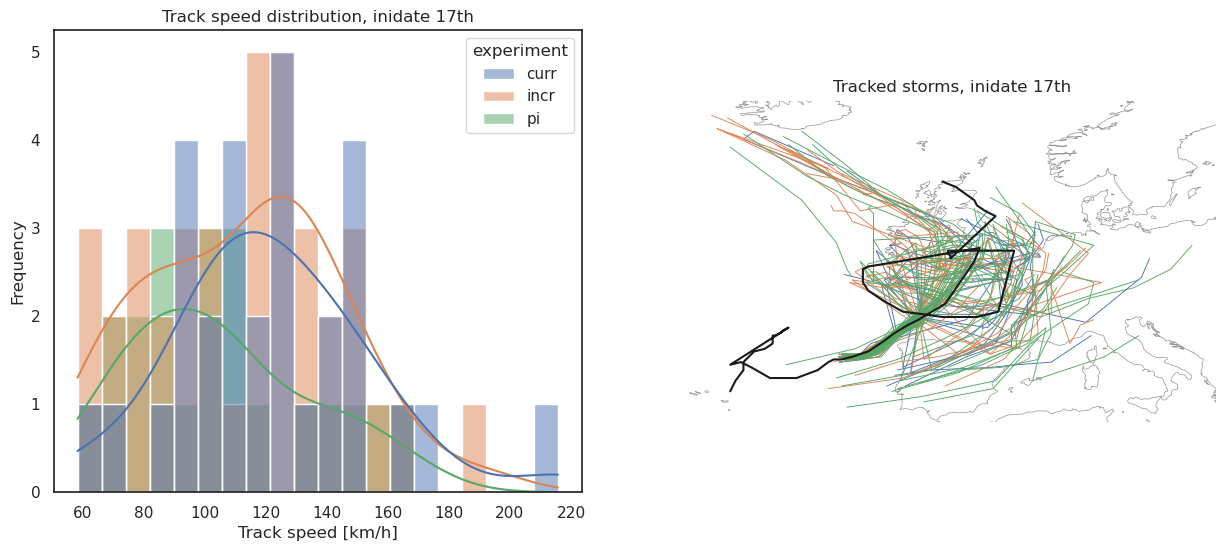

In [12]:
# plot histograms of track speeds in experiments, only tracks with inidate 2023-10-17
fig = plt.figure(figsize=(15, 6))

# add horizontal line for ERA5 speed
# ax.axvline(ERA5_babet_speed.track_speed.iloc[0], color='black', linestyle='--')
ax1 = fig.add_subplot(1, 2, 1)
sns.histplot(ifs_babet_list_speed.where(ifs_babet_list_speed.inidate=='2023-10-17'), x='track_speed', hue='experiment', bins=20, kde=True, ax=ax1)
ax1.set_xlabel('Track speed [km/h]')
ax1.set_ylabel('Frequency')
ax1.set_title('Track speed distribution, inidate 17th')

# plot maps of track locations
# Sort the data by 'date'
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ifs_babet_list_17= ifs_babet_list.where(ifs_babet_list.inidate=='2023-10-17').sort_values('date')
g=sns.lineplot(data=ifs_babet_list_17,
              x='lon',y='lat',
              hue='experiment',
              hue_order=['pi','curr','incr'],
              size='number',
              units='track_id',
              sort=False,
              estimator=None,
              sizes=(0.66,0.66),
            #   kind='line',
            #   height=4.5,
              legend=False,
            #   aspect=3, 
              ax=ax2)

# ERA5 track
ax2.plot(babet_track.lon, babet_track.lat, color='k')

# Add coastlines and remove axis ticks
ax2.set_title('Tracked storms, inidate 17th')
ax2.coastlines(color='xkcd:grey',lw=0.5)
ax2.axis('off')


In [22]:
ifs_babet_list_speed

,experiment,inidate,number,track_id,date,track_speed,track_time,track_dist
0,curr,2023-10-15,1,0,2023-10-15 00:00:00,211.649989,168.0,5079.599732
1,curr,2023-10-15,2,0,2023-10-15 00:00:00,191.161459,156.0,4587.875011
2,curr,2023-10-15,4,0,2023-10-15 00:00:00,171.495384,144.0,4115.889222
3,curr,2023-10-15,5,0,2023-10-15 00:00:00,215.947241,168.0,5182.733786
4,curr,2023-10-15,7,0,2023-10-15 00:00:00,208.332777,126.0,4999.986639
...,...,...,...,...,...,...,...,...
242,pi,2023-10-17,45,0,2023-10-19 12:00:00,92.851310,54.0,2228.431432
243,pi,2023-10-17,46,0,2023-10-17 00:00:00,113.299176,72.0,2719.180227
244,pi,2023-10-17,47,0,2023-10-17 00:00:00,137.330107,114.0,3295.922567
245,pi,2023-10-17,48,0,2023-10-17 00:00:00,102.601447,114.0,2462.434733


In [43]:
# Add precipitation to the track speed DataFrame
ifs_babet_list_speed_2 = ifs_babet_list_speed.copy(deep=True)
ifs_babet_list_speed_2['precipitation'] = ifs_babet_list_speed.apply(lambda x: float(tp_exp_index[x.experiment].sel(number=x.number, inidate=x.inidate).values), axis=1)

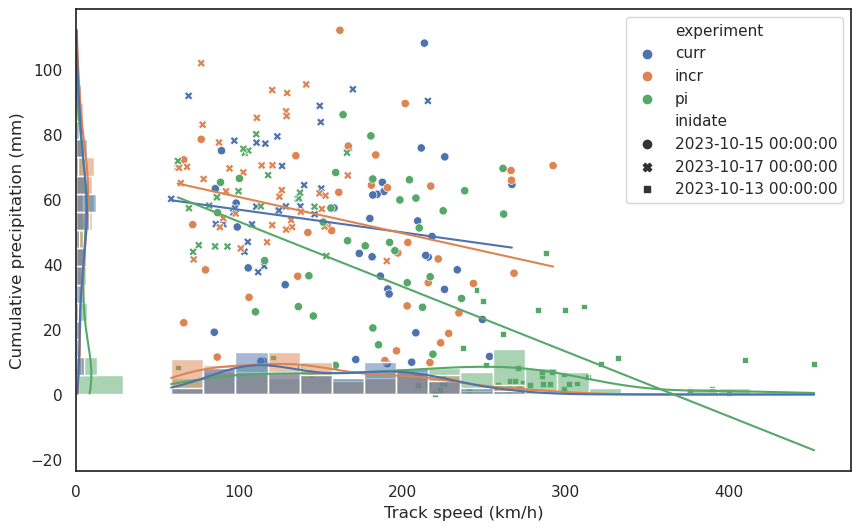

In [79]:
# Scatter plot of track speed vs precipitation index
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
scatter = sns.scatterplot(data=ifs_babet_list_speed_2, 
                        x='track_speed', 
                        y='precipitation', 
                        style='inidate',
                        hue='experiment',
                        ax=ax1)
plt.ylabel('Cumulative precipitation (mm)')
plt.xlabel('Track speed (km/h)')
# Get handles and labels for scatterplot legend
handles, labels = scatter.get_legend_handles_labels()

# Add marginal distributions
sns.histplot(ifs_babet_list_speed_2, x='track_speed', 
             ax=ax1, 
             hue='experiment', 
             bins=20, 
             kde=True, 
             alpha=0.5)
sns.histplot(ifs_babet_list_speed_2, y='precipitation',
                ax=ax1, 
                hue='experiment', 
                bins=20, 
                kde=True, 
                alpha=0.5, 
                legend=False, 
                orientation='horizontal')

# Add linear regression lines
for exp in ifs_babet_list_speed_2.experiment.unique():
    x = ifs_babet_list_speed_2.query('experiment=="{}"'.format(exp)).track_speed
    x_lm = np.linspace(x.min(), x.max(), 100) # higher resolution for plotting
    y = ifs_babet_list_speed_2.query('experiment=="{}"'.format(exp)).precipitation
    m, b = np.polyfit(x, y, 1)
    plt.plot(x_lm, m*x_lm + b, label='{}: y={:.2f}x+{:.2f}'.format(exp, m, b))

plt.legend(handles=handles, labels=labels)

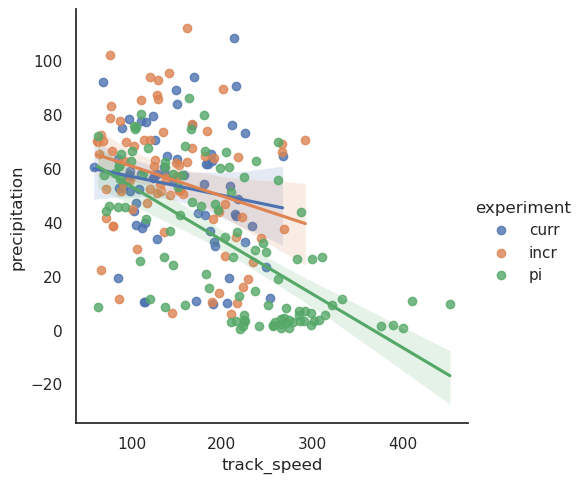

In [75]:
# Regression plot
sns.lmplot(data=ifs_babet_list_speed_2, 
                x='track_speed', 
                y='precipitation', 
                # col='inidate',
                hue='experiment')